# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nud5epz_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=5+5)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3342 seconds.


In [5]:
gm = GenerativeModel(region, model_data, delay=5)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3266 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=5)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3283 seconds.


## Summarize Model Output

In [7]:
result = summarize_inference_data(gm.inference_data)
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)

In [8]:
result.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-08-16,1.092109,1.093031,1.017082,1.165255,1821.781555,1851.693492,2410.241968,1068,11621
2020-08-17,1.099732,1.099122,1.027081,1.178670,1849.987961,1847.638609,1738.289680,1650,24894
2020-08-18,1.104593,1.104599,1.023846,1.179641,1881.129742,1845.827116,1614.829814,1649,26781
2020-08-19,1.108124,1.106094,1.029732,1.179418,1915.455403,1846.454389,1578.954581,1640,27240
2020-08-20,1.110098,1.105294,1.033980,1.181218,1952.575735,1849.705265,1400.342456,1487,27849
2020-08-21,1.111176,1.112029,1.037877,1.187728,1991.827116,1855.736199,1485.300560,1493,26362
2020-08-22,1.114270,1.114575,1.032178,1.183354,2032.722092,1864.661089,1772.670586,711,10519
2020-08-23,1.116227,1.114234,1.024536,1.177430,2074.966665,1876.545218,2007.307956,965,12608
2020-08-24,1.116308,1.113853,1.036197,1.187412,2118.833250,1891.430152,1730.130756,1900,28801


In [9]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-08-16,1.242248,1.241622,1.149317,1.328164,1698.445409,1476.296709,1068.0,1068,100000
2020-08-17,1.256782,1.252798,1.165585,1.335389,1767.969947,1488.224299,1650.0,1650,100000
2020-08-18,1.270683,1.269386,1.179259,1.352345,1845.103932,1503.969306,1649.0,1649,100000
2020-08-19,1.280955,1.279063,1.186160,1.368839,1930.093958,1523.846002,1640.0,1640,100000
2020-08-20,1.290439,1.288071,1.210384,1.396619,2023.575946,1548.199010,1487.0,1487,100000
2020-08-21,1.295622,1.294009,1.210875,1.397273,2125.619534,1577.348926,1493.0,1493,100000
2020-08-22,1.301244,1.306641,1.205026,1.401787,2236.230112,1611.620388,711.0,711,100000
2020-08-23,1.303169,1.304959,1.197777,1.397701,2355.158034,1651.387690,965.0,965,100000
2020-08-24,1.304060,1.301911,1.201228,1.397248,2482.368231,1697.038802,1900.0,1900,100000


In [10]:
resultsev.tail(30)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-09-14,0.987910,0.985507,0.905301,1.069194,87.804682,74.297409,75.0,75.0,10000
2020-09-15,0.975783,0.973445,0.898041,1.062721,87.886239,76.738320,62.0,62.0,10000
2020-09-16,0.965097,0.963826,0.880556,1.040852,87.741497,79.217234,88.0,88.0,10000
2020-09-17,0.955881,0.954133,0.870087,1.035060,87.387543,81.713292,91.0,91.0,10000
2020-09-18,0.948987,0.942138,0.856623,1.035143,86.846918,84.203236,83.0,83.0,10000
2020-09-19,0.941409,0.934536,0.854879,1.038053,86.146652,86.661939,86.0,86.0,10000
2020-09-20,0.935031,0.931536,0.828419,1.018528,85.322640,89.061560,80.0,80.0,10000
2020-09-21,0.929309,0.927789,0.820665,1.017007,84.392413,91.372620,115.0,115.0,10000
2020-09-22,0.928038,0.926825,0.806646,1.019232,83.365268,93.564895,98.0,98.0,10000


## Plot Model Output

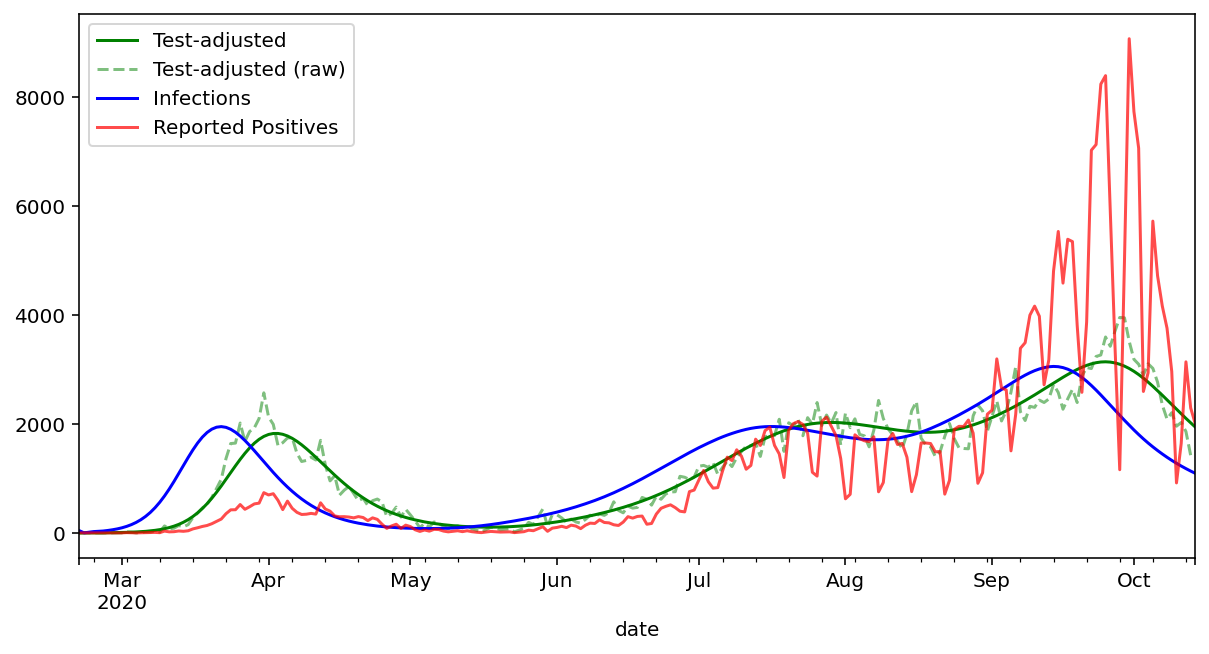

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

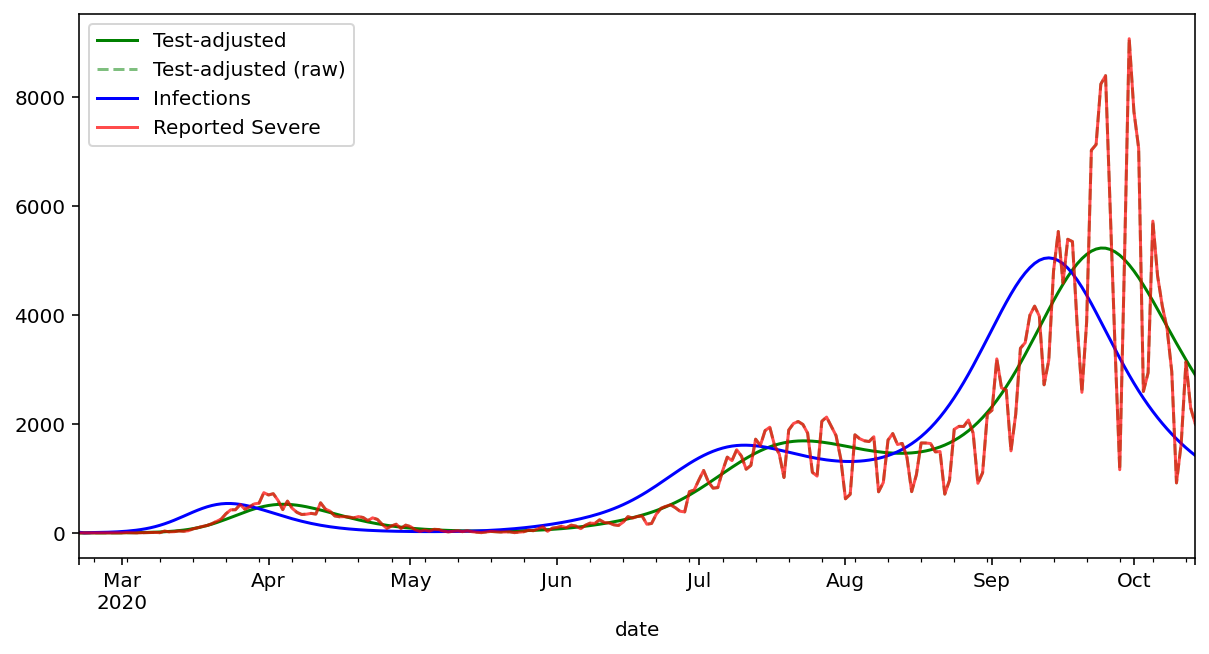

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
ax.legend();

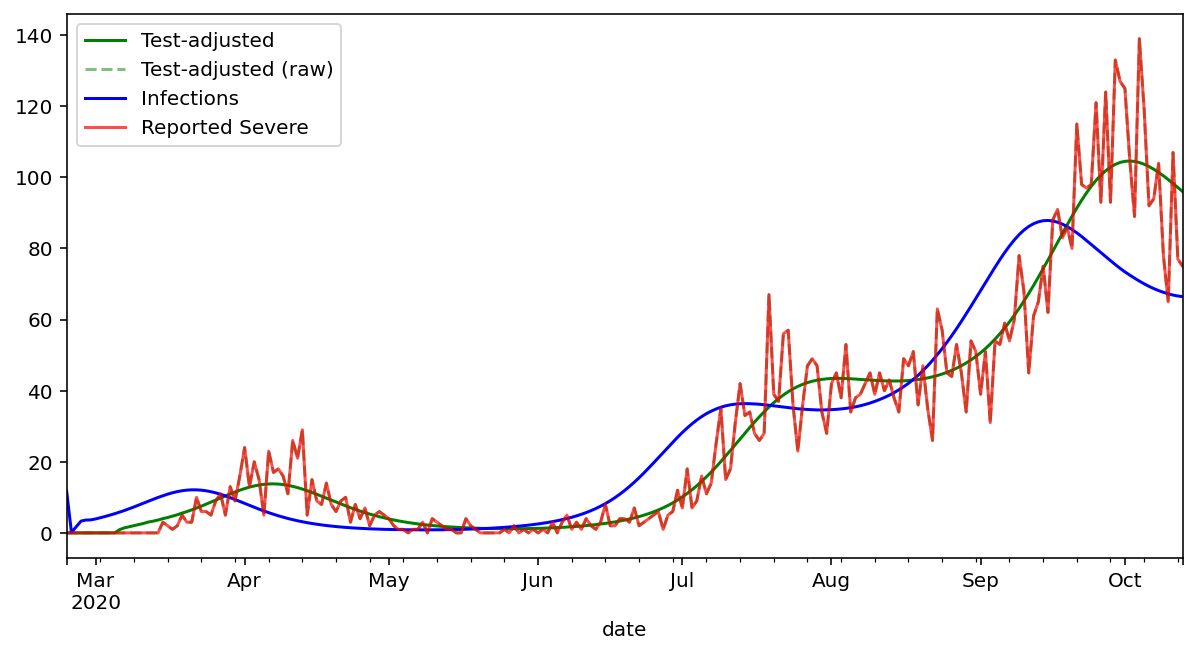

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
ax.legend();

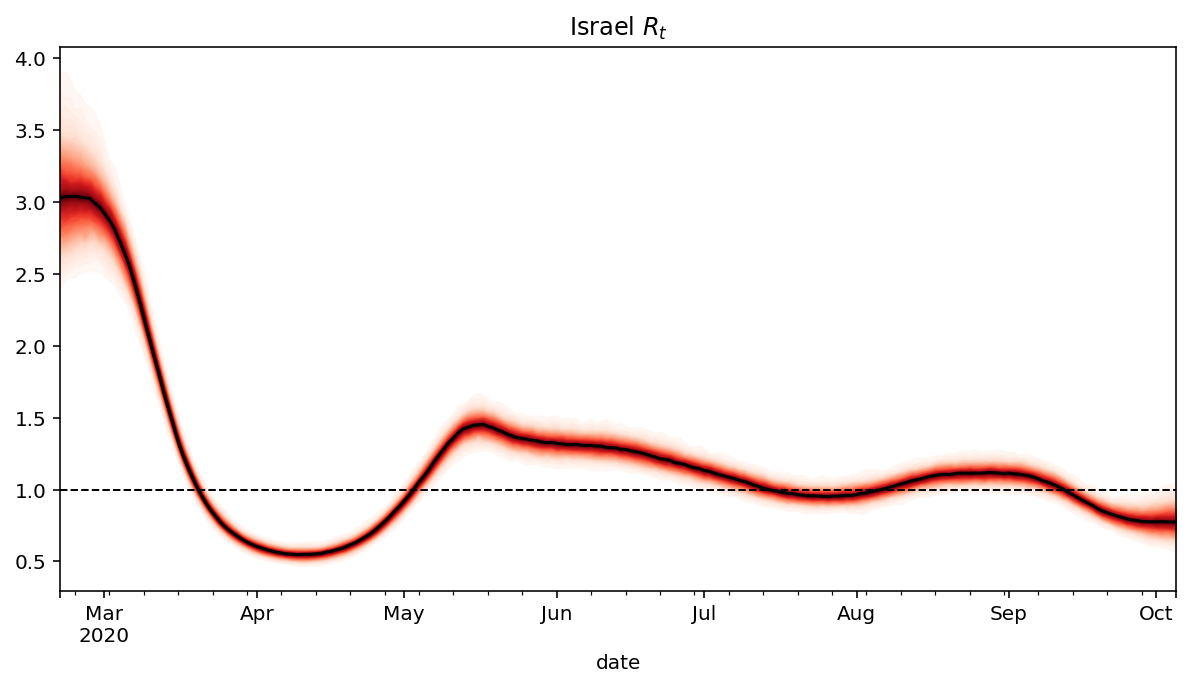

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')

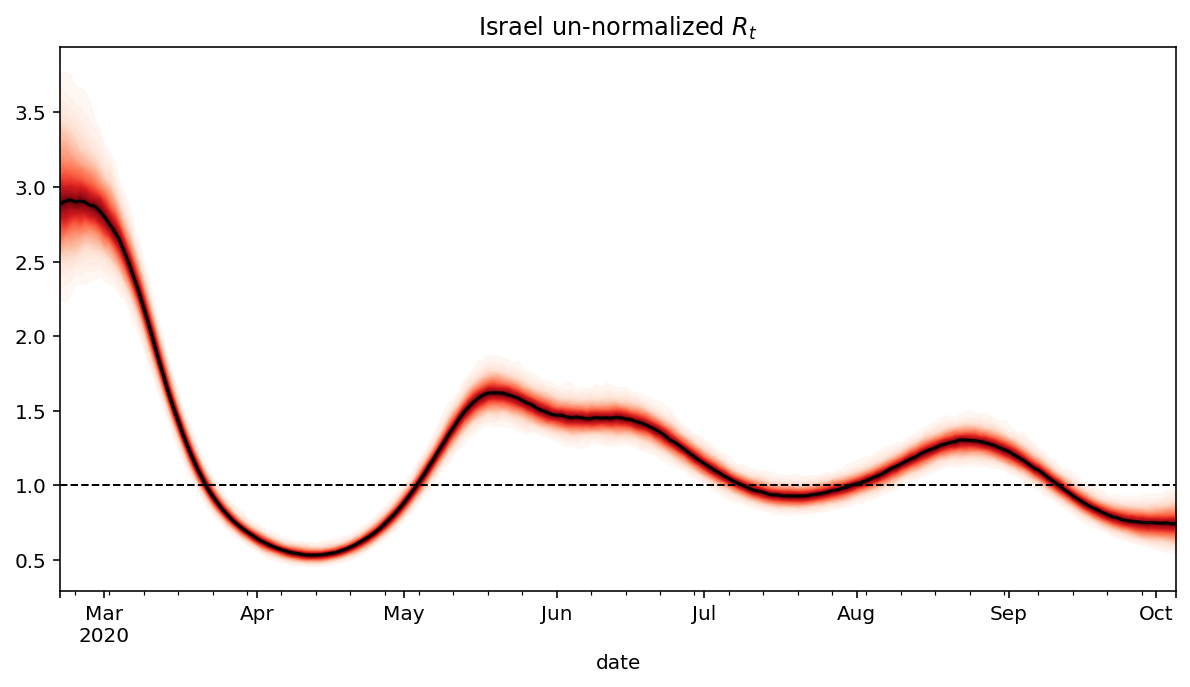

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')

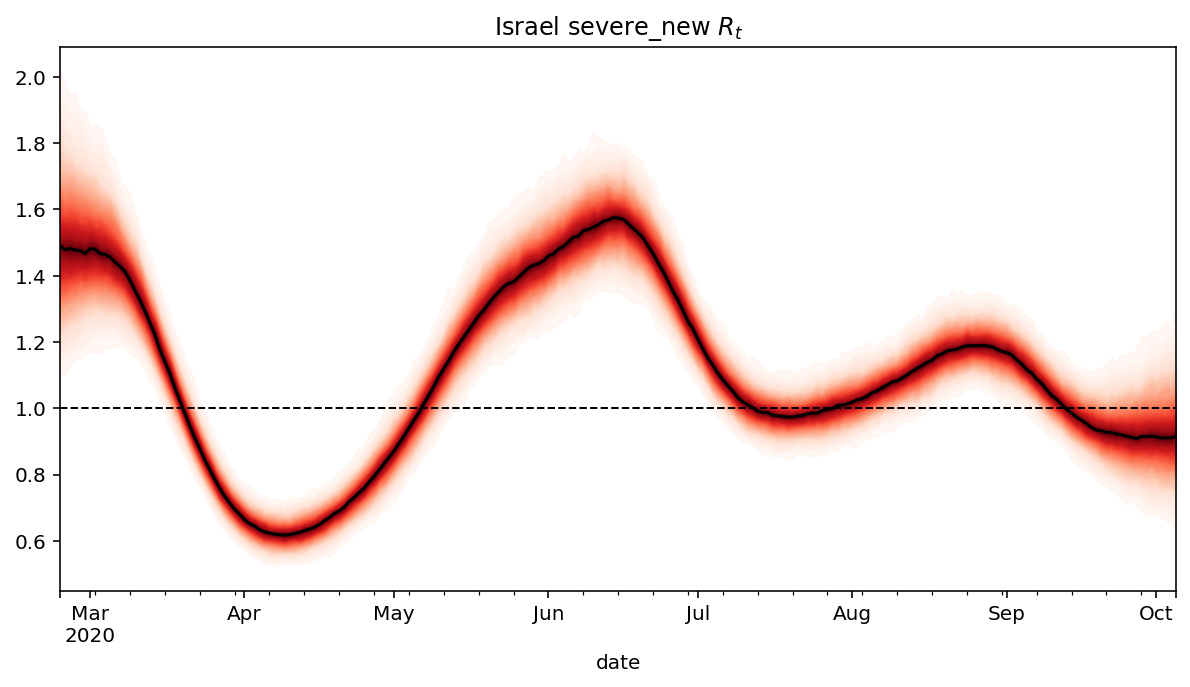

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')